# Transfer Learning on Azerbaijan Sign Language Dataset

The dataset of this notebook can be found on [kaggle](https://www.kaggle.com/datasets/aykhannazimzada/azsl-dataset).

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Imports

The following cells import the libraries needed for this project.

In [4]:
import tensorflow as tf
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
!curl -L -o azsl-dataset.zip https://www.kaggle.com/api/v1/datasets/download/aykhannazimzada/azsl-dataset
!unzip -oq azsl-dataset.zip -d "azsl-dataset"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3241M  100 3241M    0     0   110M      0  0:00:29  0:00:29 --:--:--  126M


## Load Dataset

The dataset is structured into folders. Each folder has the name of the `label` and contains all relevant `images` of this label.

This allows us to use the `image_dataset_from_directory` method from keras to quickly load the datase.

We __normalize__ the dataset and split it into:

- train set
- validation set (15% of the train set)
- test set (15% of total)


In [5]:
# A quick check to find the dimentionality of the images
from PIL import Image

img = Image.open("/kaggle/working/azsl-dataset/AzSL Dataset/A/A1.jpg")

print(f'Image dimentions: {img.size}')

Image dimentions: (720, 1280)


In [6]:
def get_class_names(dataset, verbose: bool = False):
    class_names = set()

    for _, labels in tqdm(dataset, desc="Calculating class names"):
        for label in labels:
            class_names.add(str(label))

    if verbose:
        print(f"Unique Dataset Labels: {class_names}")

    return class_names

In [7]:
dataset_path = "/kaggle/working/azsl-dataset/AzSL Dataset/"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode="categorical",
    # Resize the image to be compatible with MobileNet
    image_size=(224, 224),
    batch_size=64,
    shuffle=True,
    seed=42,
)

train_size = int(len(dataset) * 0.7)

train_dataset = dataset.take(train_size)
temp_dataset = dataset.skip(train_size)
val_dataset = temp_dataset.take(int(0.5 * len(temp_dataset)))
test_dataset = temp_dataset.skip(int(0.5 * len(temp_dataset)))

def normalize_image(image, label):
    # TODO: Calculate mean, std for the images
    precomputed_mean = [0.5590047240257263, 0.49885866045951843, 0.4555515944957733]
    precomputed_std = [0.6033478379249573, 0.5458617806434631, 0.5077916383743286]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std

    return image, label

del temp_dataset

buffer_size = 1
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)

train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

print(f'Train batches: {len(train_dataset)}')
print(f'Validation batches: {len(val_dataset)}')
print(f'Test batches: {len(test_dataset)}')

Found 10948 files belonging to 32 classes.
Train batches: 120
Validation batches: 26
Test batches: 26


(64, 32)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 32), dtype=float32)


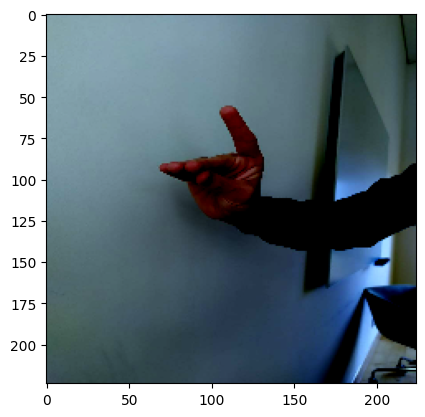

In [8]:
images, labels = next(iter(train_dataset))

print(labels.shape)
print(labels)

plt.imshow(images[0])

## Useful Methods

The following cells contain methods used to simplify the code

In [8]:
from sklearn.metrics import confusion_matrix

def get_class_count(dataset):
    """Find out how many elements bellong to each class
    This method is used in plot_class_distribution to plot
    the distribution of the data
    
    Return:
        class_counts: A dictionary with the class name as a key
        and the total items as a value
    """
    class_counts = {}
    for images, labels in tqdm(dataset):
        for label in labels:
            # Here the label is a tensor with 1 element
            # We have to convert it to numpy
            label = label.numpy()
            # Since it's one hot get the possition of the 1
            label_pos = np.where(label == 1)[0][0]
            # Count it
            class_counts[label_pos] = class_counts.get(label_pos, 0) + 1
    # Return the counts
    return class_counts

def plot_class_distribution(dataset, title: str):
    
    # Get the class counts
    class_counts = get_class_count(dataset)

    df = pd.DataFrame(class_counts, index=list(range(len(class_counts))))

    # Sort the columns
    df = df.reindex(sorted(df.columns), axis=1)

    # Set the figure size
    plt.figure(figsize=(12, 6))
    # Add the data
    ax = sns.barplot(df)
    # Set the title
    ax.set_title(title)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    # Adjust layout to make room for rotated labels
    plt.tight_layout()
    plt.show()

def plot_history(history):
    """Plot the loss and accuracy of the models."""
    
    # Convert the object to a DataFrame for easier access
    history_df = pd.DataFrame(history.history)

    # Set the style of seaborn
    sns.set(style='whitegrid')

    # Create a figure with a specific size
    plt.figure(figsize=(14, 6))

    #############
    # Loss plot #
    #############
    plt.subplot(1, 2, 1)
    sns.lineplot(data=history_df[['loss', 'val_loss']], palette='tab10', dashes=False, linewidth=2)
    plt.title('Model Loss', fontsize=16)
    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(['Train Loss', 'Validation Loss'], fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)

    #################
    # Accuracy plot #
    #################
    plt.subplot(1, 2, 2)
    sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], palette='tab10', dashes=False, linewidth=2)
    plt.title('Model Accuracy', fontsize=16)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(['Train Accuracy', 'Validation Accuracy'], fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def get_total_classes(dataset):
    for images, labels in dataset:
        return labels.shape[1]

## Visualizations

Bellow we can see some visualizations for this dataset

100%|██████████| 120/120 [00:40<00:00,  2.98it/s]


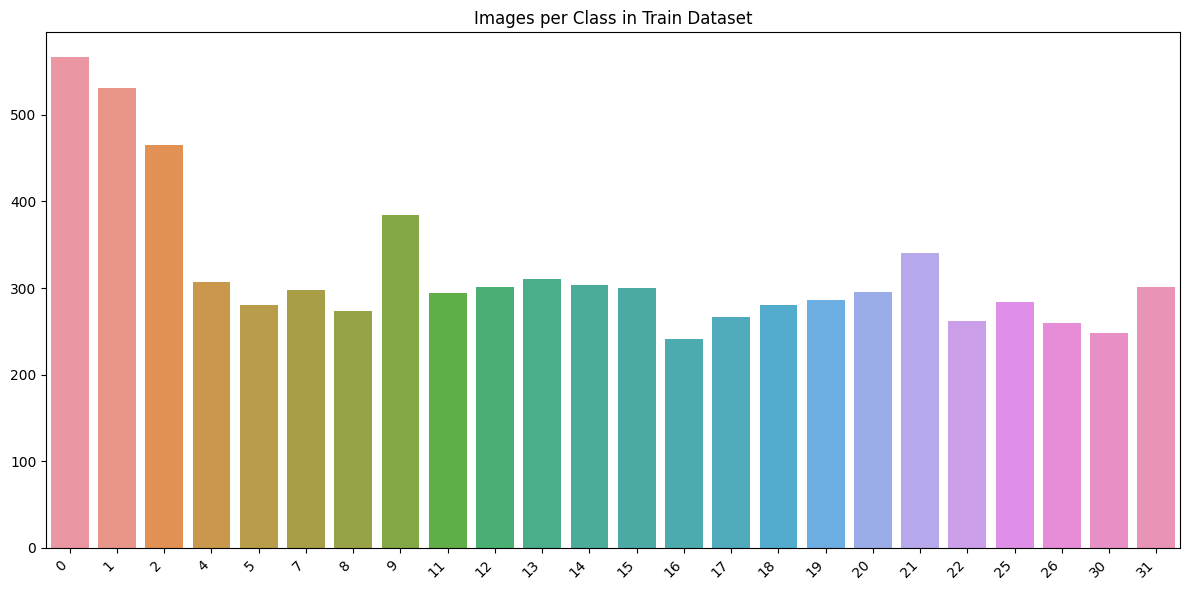

In [12]:
plot_class_distribution(train_dataset, "Images per Class in Train Dataset")

100%|██████████| 26/26 [00:44<00:00,  1.70s/it]


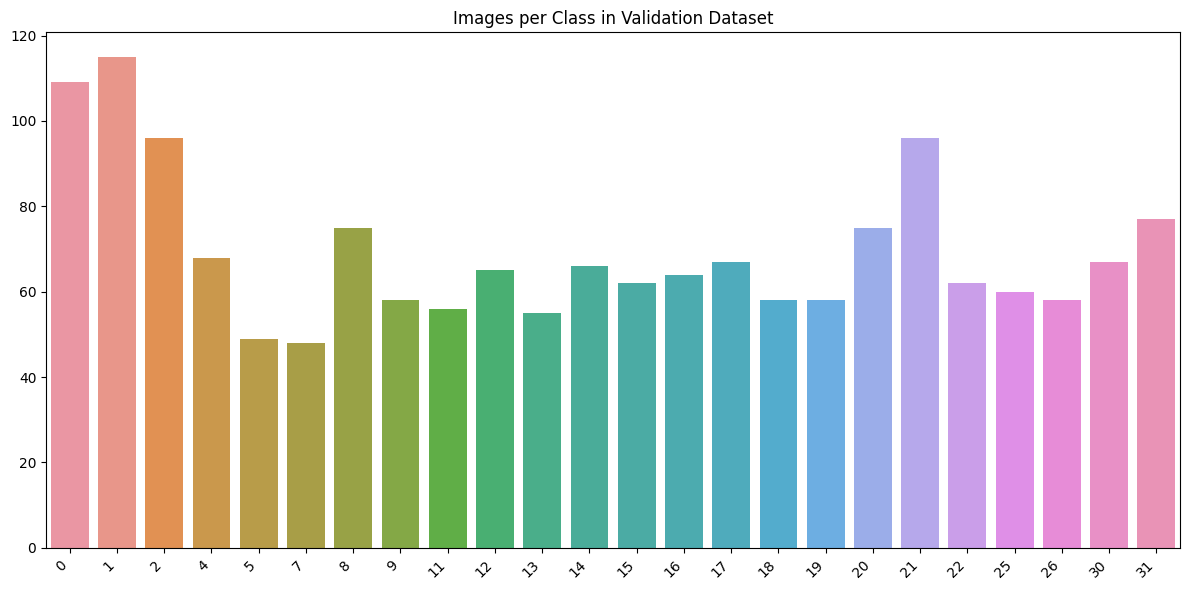

In [13]:
plot_class_distribution(val_dataset, "Images per Class in Validation Dataset")

100%|██████████| 26/26 [00:49<00:00,  1.89s/it]


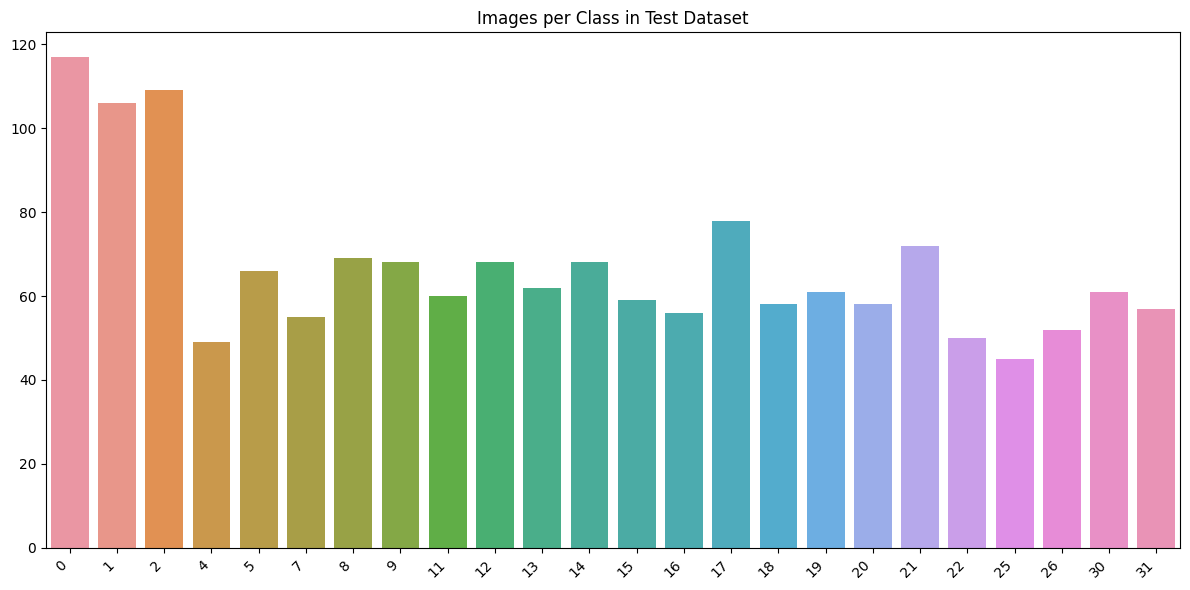

In [14]:
plot_class_distribution(test_dataset, "Images per Class in Test Dataset")

## MobileNet Transfer Learning

Let's try to finetune `MobileNetV2` for our task.

MobileNetV2 is trained on the `imagenet` dataset.

Due to the fact that it works with some specific image sizes, we have to reshape our images from (720, 1280) to (224, 224, 3)

In [6]:
for images, labels in tqdm(test_dataset):
    NUM_CLASSES = labels.shape[1]
    break

NUM_CLASSES

  0%|          | 0/411 [00:00<?, ?it/s]

2025-02-04 21:25:55.394897: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23970816 exceeds 10% of free system memory.
2025-02-04 21:25:55.513528: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23970816 exceeds 10% of free system memory.
2025-02-04 21:25:56.174348: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23970816 exceeds 10% of free system memory.
2025-02-04 21:25:56.245804: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23970816 exceeds 10% of free system memory.
2025-02-04 21:25:56.328770: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23970816 exceeds 10% of free system memory.
  0%|          | 0/411 [01:20<?, ?it/s]


32

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           4,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,426,592 (9.26 MB)

 Trainable params: 168,352 (657.62 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

None
Epoch 1/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 72s 537ms/step - accuracy: 0.1751 - loss: 3.0052 - val_accuracy: 0.4237 - val_loss: 1.9021
Epoch 2/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 537ms/step - accuracy: 0.5132 - loss: 1.6539 - val_accuracy: 0.5210 - val_loss: 1.5453
Epoch 3/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 536ms/step - accuracy: 0.6162 - loss: 1.2787 - val_accuracy: 0.5649 - val_loss: 1.3690
Epoch 4/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 536ms/step - accuracy: 0.6772 - loss: 1.0659 - val_accuracy: 0.5889 - val_loss: 1.3161
Epoch 5/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 65s 541ms/step - accuracy: 0.7345 - loss: 0.8839 - val_accuracy: 0.6118 - val_loss: 1.2415
Epoch 6/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 538ms/step - accuracy: 0.7780 - loss: 0.7595 - val_accuracy: 0.6334 - val_loss: 1.1868
Epoch 7/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 534ms/step - accuracy: 0.8144 - loss: 0.6383 - val_accuracy: 0.6562 - val_loss: 1.1579
New best model found


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

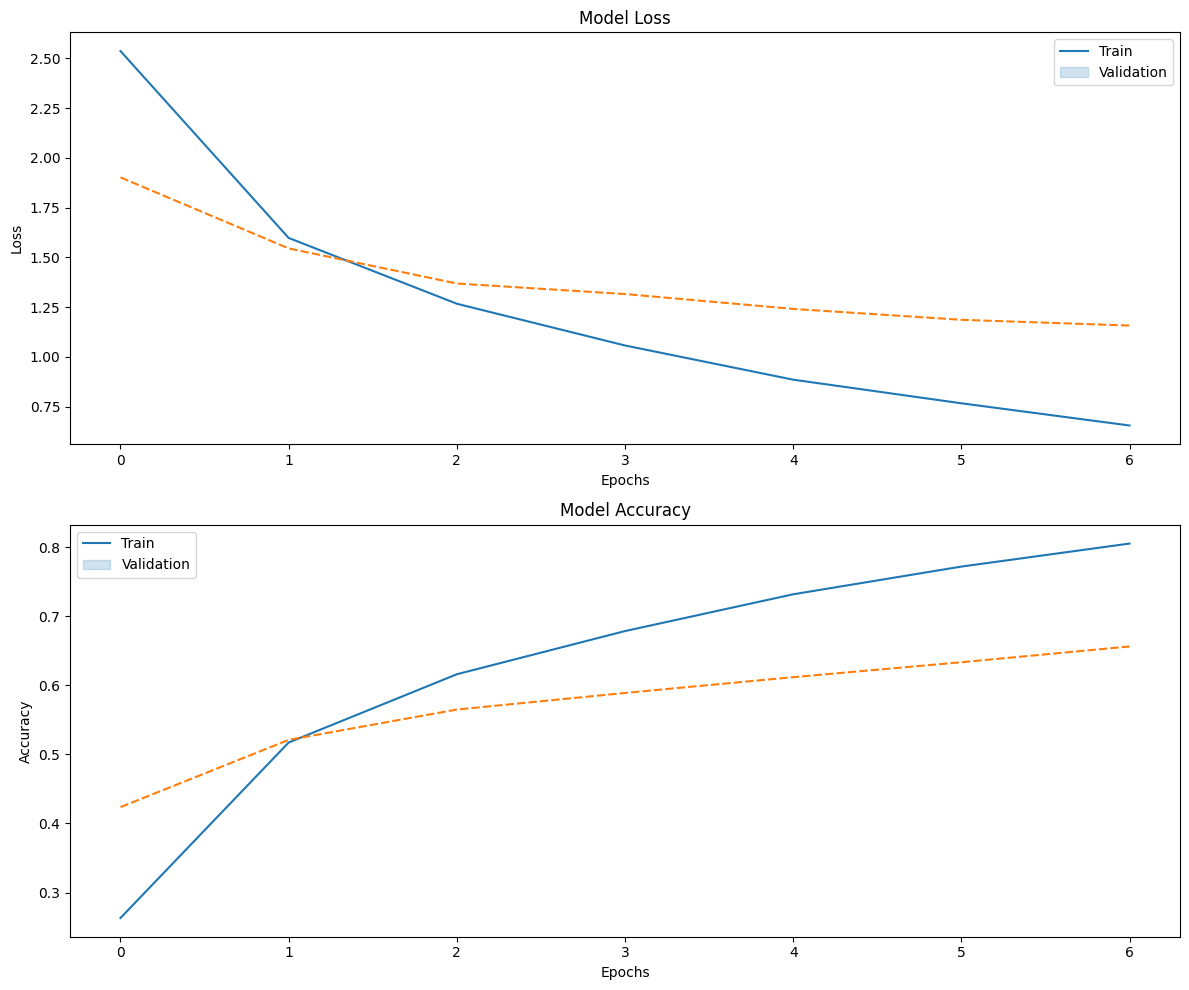

---------------------------
---------------------------
HIDDEN SIZE: 256
---------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           8,224 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,595,168 (9.90 MB)

 Trainable params: 336,672 (1.28 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

None
Epoch 1/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 72s 534ms/step - accuracy: 0.2039 - loss: 2.8631 - val_accuracy: 0.4760 - val_loss: 1.7066
Epoch 2/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 530ms/step - accuracy: 0.5878 - loss: 1.3655 - val_accuracy: 0.5679 - val_loss: 1.3988
Epoch 3/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 530ms/step - accuracy: 0.6913 - loss: 1.0162 - val_accuracy: 0.5751 - val_loss: 1.3294
Epoch 4/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 538ms/step - accuracy: 0.7595 - loss: 0.8064 - val_accuracy: 0.6412 - val_loss: 1.1707
Epoch 5/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 538ms/step - accuracy: 0.8257 - loss: 0.6201 - val_accuracy: 0.6478 - val_loss: 1.1665
Epoch 6/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 538ms/step - accuracy: 0.8594 - loss: 0.5078 - val_accuracy: 0.6701 - val_loss: 1.0920
Epoch 7/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 538ms/step - accuracy: 0.8874 - loss: 0.4172 - val_accuracy: 0.6851 - val_loss: 1.0664
New best model found


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

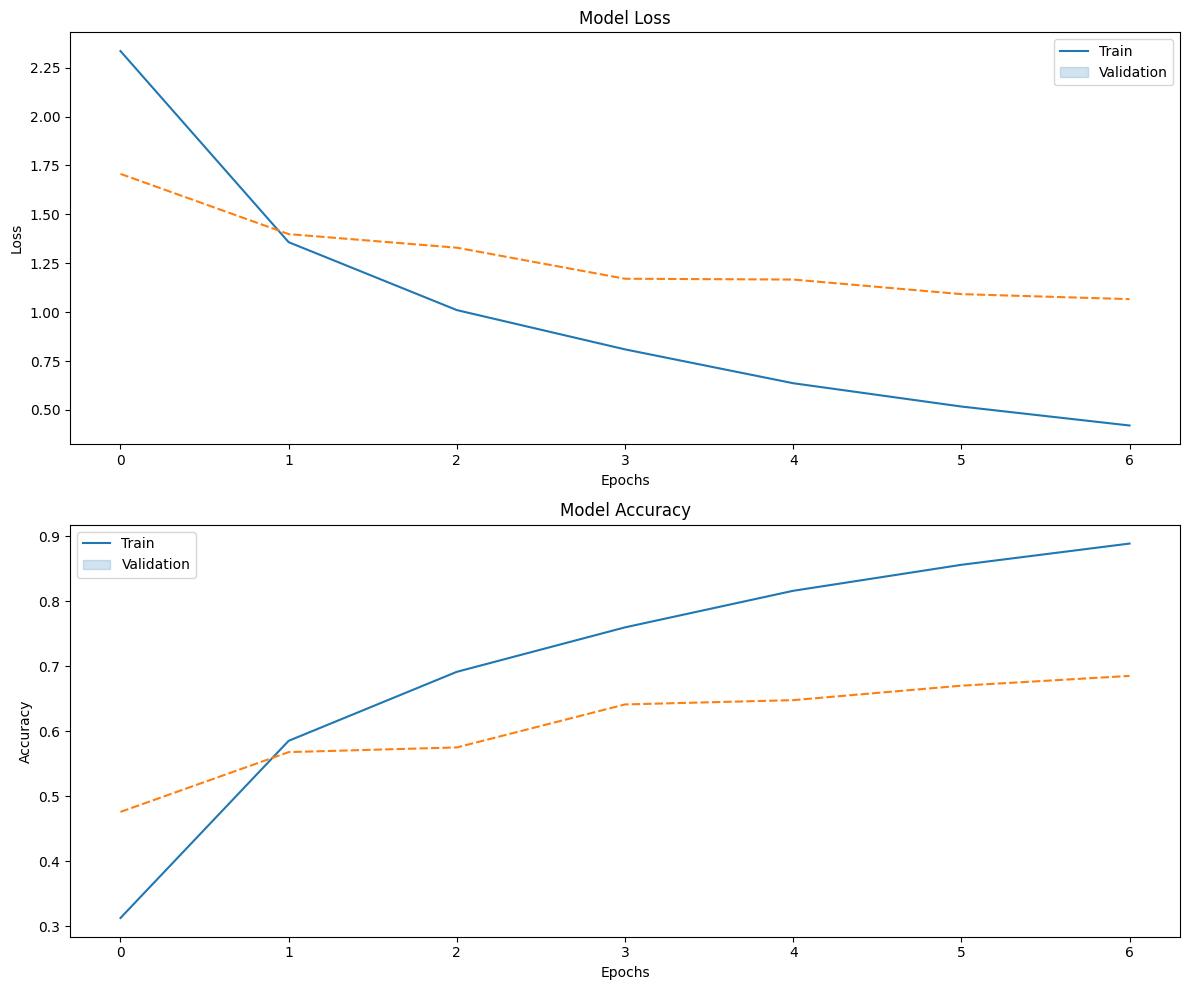

---------------------------
---------------------------
HIDDEN SIZE: 512
---------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │          16,416 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,932,320 (11.19 MB)

 Trainable params: 673,312 (2.57 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

None
Epoch 1/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 73s 538ms/step - accuracy: 0.2512 - loss: 2.6314 - val_accuracy: 0.5156 - val_loss: 1.5478
Epoch 2/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 538ms/step - accuracy: 0.6620 - loss: 1.1064 - val_accuracy: 0.5992 - val_loss: 1.2806
Epoch 3/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 65s 540ms/step - accuracy: 0.7777 - loss: 0.7672 - val_accuracy: 0.6556 - val_loss: 1.1448
Epoch 4/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 65s 543ms/step - accuracy: 0.8443 - loss: 0.5594 - val_accuracy: 0.6569 - val_loss: 1.1080
Epoch 5/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 73s 607ms/step - accuracy: 0.8933 - loss: 0.4106 - val_accuracy: 0.6959 - val_loss: 1.0513
Epoch 6/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 65s 542ms/step - accuracy: 0.9342 - loss: 0.3006 - val_accuracy: 0.6803 - val_loss: 1.0548
Epoch 7/7
120/120 ━━━━━━━━━━━━━━━━━━━━ 65s 543ms/step - accuracy: 0.9519 - loss: 0.2210 - val_accuracy: 0.6977 - val_loss: 1.0578
New best model found


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

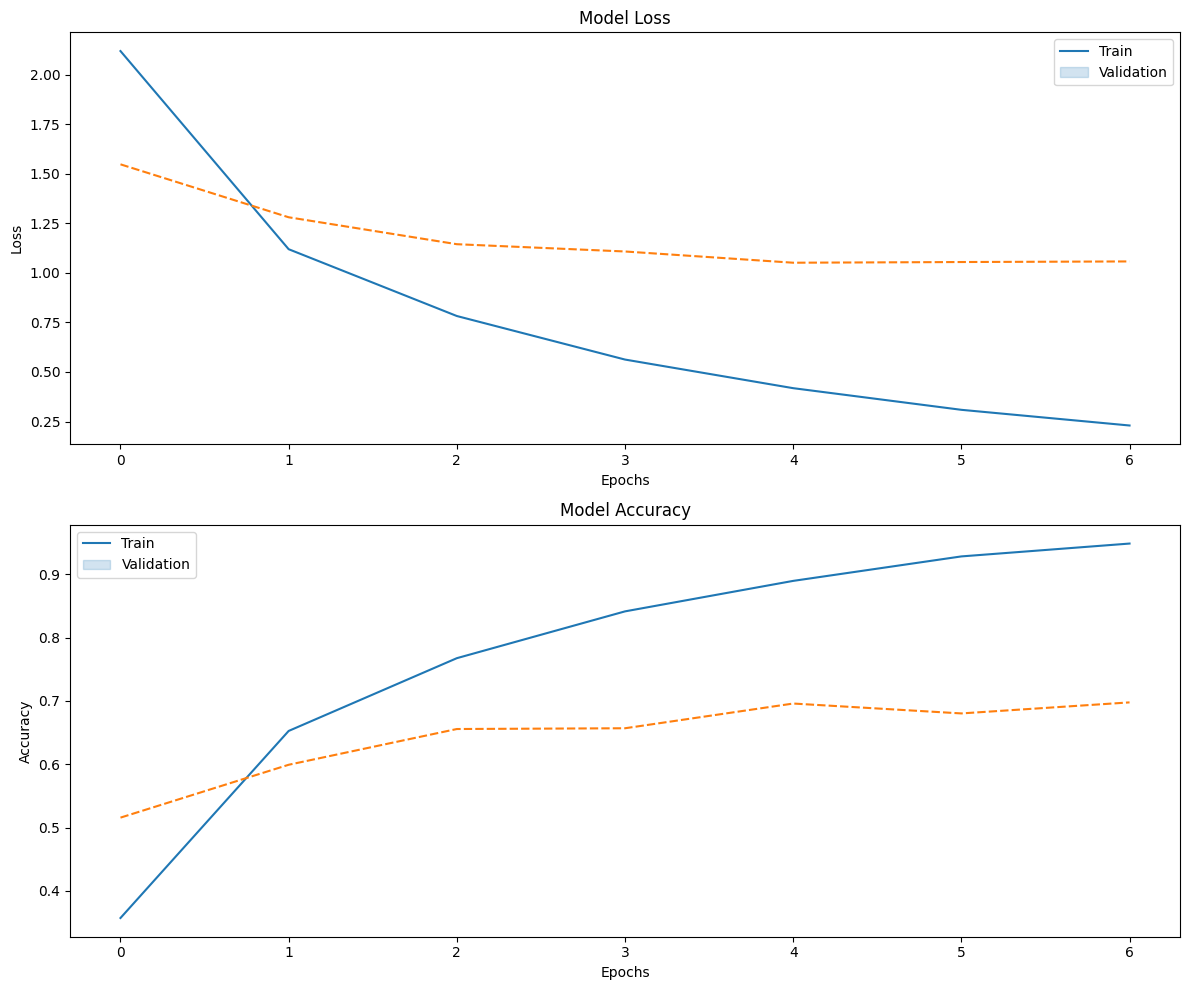

26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 312ms/step - accuracy: 0.6266 - loss: 1.2575
Test Loss: 1.2954391241073608
Test Accuracy: 0.6221945285797119


In [12]:
hidden_sizes = [128, 256, 512]
best_model = None
best_acc = -1
for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    # TODO add mobilenet specific preprocessing
    
    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=7)

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)


# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

### Confusion Matrix

  0%|          | 0/26 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


  4%|▍         | 1/26 [00:36<15:02, 36.08s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 2/26 [00:36<05:59, 14.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 12%|█▏        | 3/26 [00:36<03:09,  8.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▌        | 4/26 [00:36<01:51,  5.07s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 19%|█▉        | 5/26 [00:36<01:09,  3.32s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 23%|██▎       | 6/26 [00:37<00:45,  2.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 27%|██▋       | 7/26 [00:37<00:30,  1.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 31%|███       | 8/26 [00:37<00:20,  1.15s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 35%|███▍      | 9/26 [00:37<00:14,  1.18it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 10/26 [00:37<00:10,  1.58it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 42%|████▏     | 11/26 [00:38<00:07,  2.00it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 46%|████▌     | 12/26 [00:38<00:05,  2.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 50%|█████     | 13/26 [00:38<00:04,  2.95it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 54%|█████▍    | 14/26 [00:38<00:03,  3.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 58%|█████▊    | 15/26 [00:38<00:02,  3.69it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 62%|██████▏   | 16/26 [00:39<00:02,  4.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 65%|██████▌   | 17/26 [00:39<00:01,  4.65it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 69%|██████▉   | 18/26 [00:39<00:01,  4.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 19/26 [00:39<00:01,  4.64it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 20/26 [00:39<00:01,  4.81it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|████████  | 21/26 [00:40<00:01,  4.80it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|████████▍ | 22/26 [00:40<00:00,  4.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 23/26 [00:40<00:00,  4.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 92%|█████████▏| 24/26 [00:40<00:00,  4.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▌| 25/26 [00:40<00:00,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


100%|██████████| 26/26 [00:43<00:00,  1.67s/it]


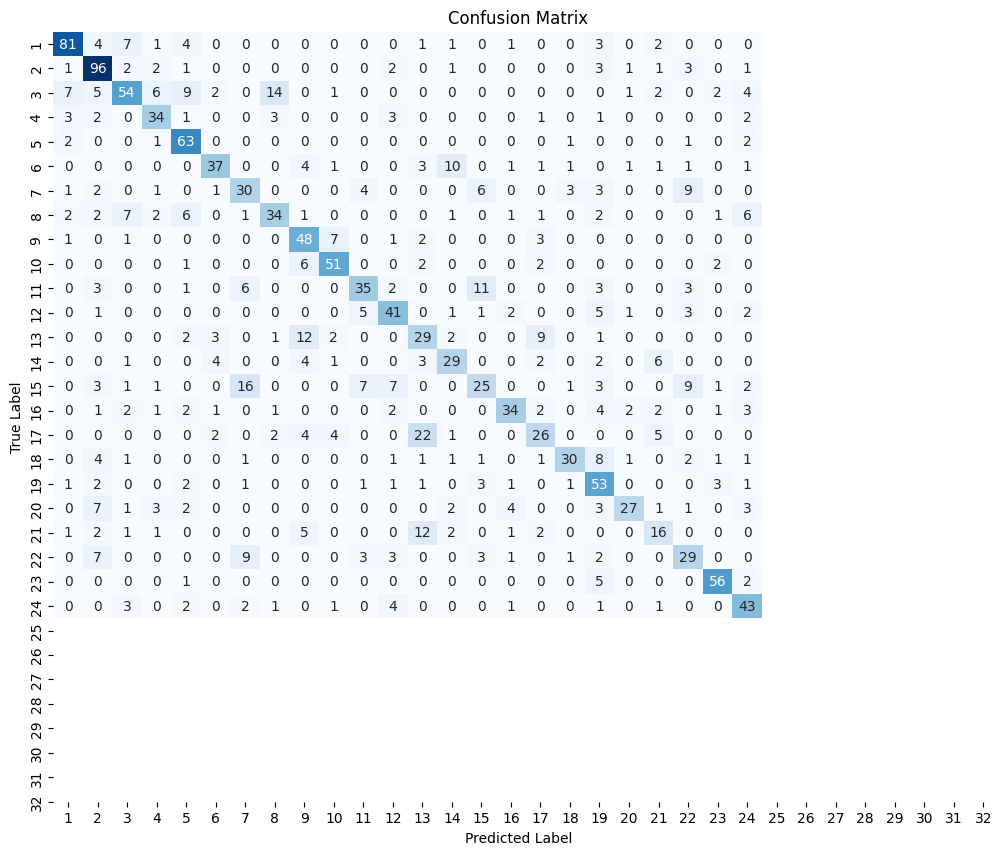

In [13]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch)
    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))

class_names = list(range(1, NUM_CLASSES + 1))
plot_confusion_matrix(y_true, y_pred, class_names)

## ConvNeXtBase Transfer Learning

Let's try to finetune `ConvNeXtBase` for our task.

`ConvNeXtBase` is trained on the `imagenet` dataset

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           4,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,702,304 (334.56 MB)

 Trainable params: 135,584 (529.62 KB)

 Non-trainable params: 87,566,720 (334.04 MB)

None
Epoch 1/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 109s 727ms/step - accuracy: 0.1262 - loss: 3.2904 - val_accuracy: 0.3005 - val_loss: 2.5504
Epoch 2/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 674ms/step - accuracy: 0.3901 - loss: 2.0760 - val_accuracy: 0.3480 - val_loss: 2.1096
Epoch 3/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 675ms/step - accuracy: 0.4947 - loss: 1.6763 - val_accuracy: 0.4062 - val_loss: 1.9418
Epoch 4/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 675ms/step - accuracy: 0.5652 - loss: 1.4310 - val_accuracy: 0.4826 - val_loss: 1.7229
Epoch 5/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 676ms/step - accuracy: 0.6179 - loss: 1.2580 - val_accuracy: 0.4880 - val_loss: 1.6211
Epoch 6/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 677ms/step - accuracy: 0.6470 - loss: 1.1521 - val_accuracy: 0.5246 - val_loss: 1.5204
Epoch 7/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 674ms/step - accuracy: 0.6794 - loss: 1.0494 - val_accuracy: 0.5216 - val_loss: 1.5335
Epoch 8/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 676ms/step - accuracy: 0.7162 - loss: 0.9

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

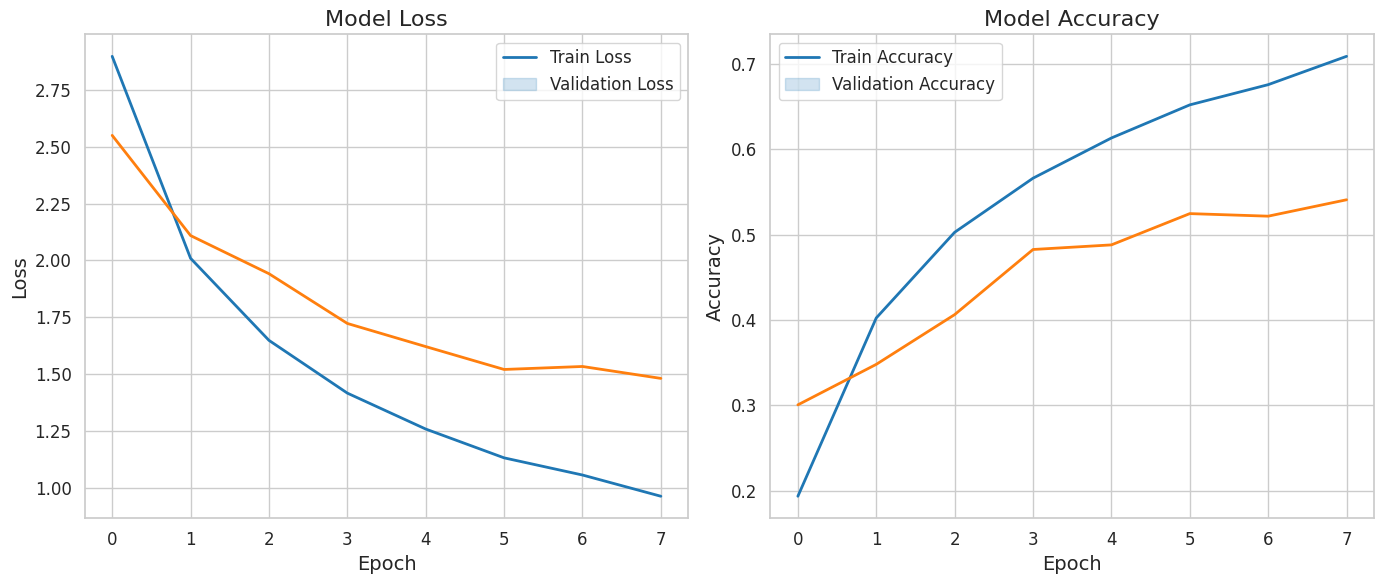

---------------------------
---------------------------
HIDDEN SIZE: 256
---------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           8,224 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,838,112 (335.08 MB)

 Trainable params: 271,136 (1.03 MB)

 Non-trainable params: 87,566,976 (334.04 MB)

None
Epoch 1/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 109s 727ms/step - accuracy: 0.1613 - loss: 3.0779 - val_accuracy: 0.3053 - val_loss: 2.3970
Epoch 2/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 679ms/step - accuracy: 0.4654 - loss: 1.7710 - val_accuracy: 0.3954 - val_loss: 1.9829
Epoch 3/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 676ms/step - accuracy: 0.5742 - loss: 1.3781 - val_accuracy: 0.4724 - val_loss: 1.7600


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

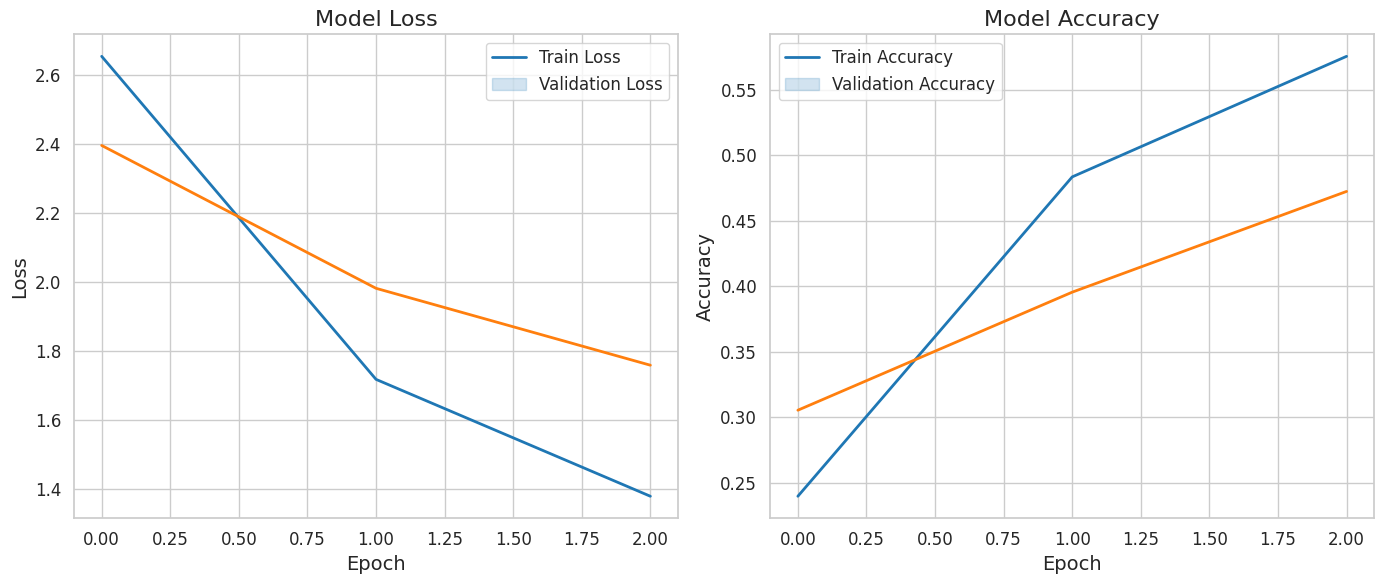

---------------------------
---------------------------
HIDDEN SIZE: 512
---------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │          16,416 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,109,728 (336.11 MB)

 Trainable params: 542,240 (2.07 MB)

 Non-trainable params: 87,567,488 (334.04 MB)

None
Epoch 1/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 109s 728ms/step - accuracy: 0.1876 - loss: 3.0448 - val_accuracy: 0.3341 - val_loss: 2.3075
Epoch 2/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 675ms/step - accuracy: 0.5163 - loss: 1.5846 - val_accuracy: 0.4279 - val_loss: 1.8768
Epoch 3/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 676ms/step - accuracy: 0.6290 - loss: 1.2182 - val_accuracy: 0.4886 - val_loss: 1.6811


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

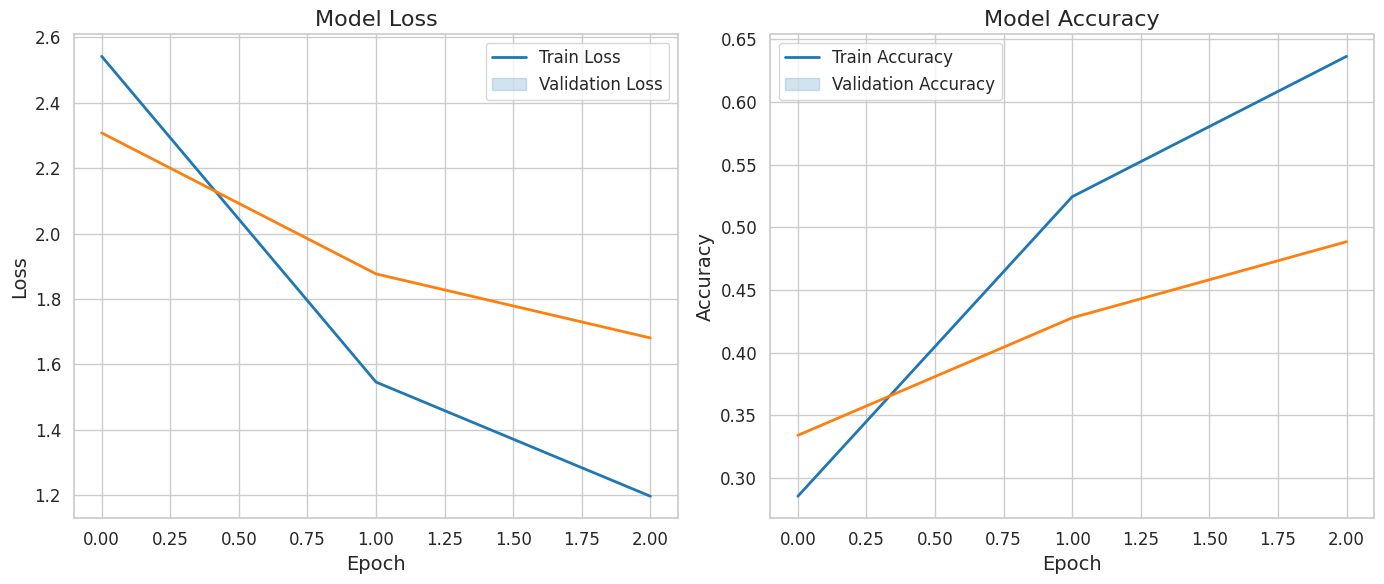

26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 439ms/step - accuracy: 0.5143 - loss: 1.5030
Test Loss: 1.532933235168457
Test Accuracy: 0.5062344074249268


In [18]:
hidden_sizes = [128, 256, 512]
best_model = None
best_acc = -1

# early stopping callback
# patience of 3 since we have a small number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.ConvNeXtBase(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    # TODO add mobilenet specific preprocessing
    
    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=8, callbacks=[early_stopping])

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)

# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

### Confusion Plot

  0%|          | 0/26 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  4%|▍         | 1/26 [00:33<13:48, 33.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 2/26 [00:33<05:34, 13.94s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 12%|█▏        | 3/26 [00:34<03:01,  7.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 15%|█▌        | 4/26 [00:35<01:51,  5.08s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 19%|█▉        | 5/26 [00:35<01:12,  3.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 23%|██▎       | 6/26 [00:36<00:48,  2.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 7/26 [00:36<00:34,  1.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 31%|███       | 8/26 [00:37<00:24,  1.38s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 35%|███▍      | 9/26 [00:37<00:18,  1.11s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 38%|███▊      | 10/26 [00:38<00:14,  1.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 42%|████▏     | 11/26 [00:38<00:11,  1.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 46%|████▌     | 12/26 [00:39<00:09,  1.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 50%|█████     | 13/26 [00:39<00:08,  1.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 54%|█████▍    | 14/26 [00:40<00:07,  1.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|█████▊    | 15/26 [00:40<00:06,  1.64it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 62%|██████▏   | 16/26 [00:41<00:05,  1.77it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▌   | 17/26 [00:41<00:04,  1.93it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▉   | 18/26 [00:42<00:03,  2.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 19/26 [00:42<00:03,  2.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 20/26 [00:42<00:02,  2.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 81%|████████  | 21/26 [00:43<00:02,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 85%|████████▍ | 22/26 [00:43<00:01,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████▊ | 23/26 [00:44<00:01,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 92%|█████████▏| 24/26 [00:44<00:00,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▌| 25/26 [00:45<00:00,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|██████████| 26/26 [00:45<00:00,  1.74s/it]


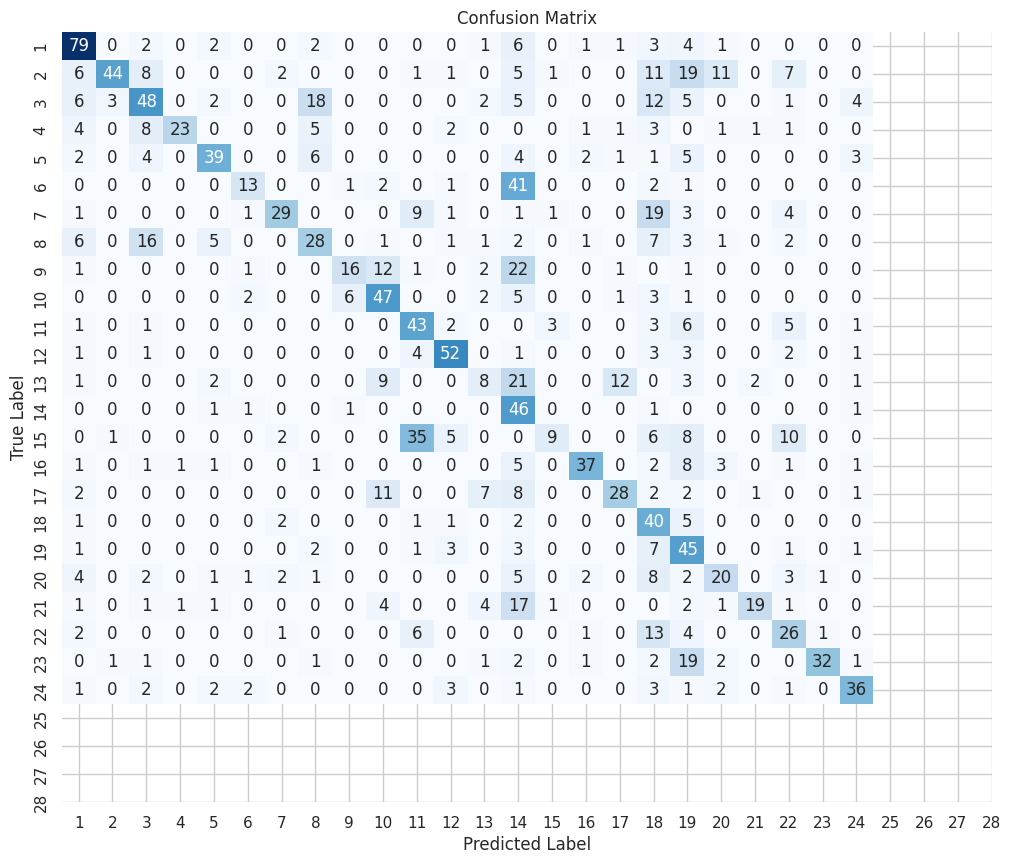

In [20]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch)
    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))

class_names = list(range(1, 28 + 1))
plot_confusion_matrix(y_true, y_pred, class_names)

## MobileNet FineTunning

Finally we will try to __finetune the entire MobileNet network__.

We expect this approach to perform better that the simple transfer learning, as we will be finetunning all the model parameters and not only the classification head.

Here, it's common to use a small learning rate.

__We will use the optimal model from the search above__, with a classification head of size `512`.

We first have to re-load the dataset with a smaller batch size, for example: `4`

In [9]:
dataset_path = "../../sign_datasets/azerbaijan-sign-language-dataset/AzSL Dataset"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode="categorical",
    # Resize the image to be compatible with MobileNet
    image_size=(224, 224),
    batch_size=4,
    shuffle=True,
    seed=42,
)

train_size = int(len(dataset) * 0.7)

train_dataset = dataset.take(train_size)
temp_dataset = dataset.skip(train_size)
val_dataset = temp_dataset.take(int(0.5 * len(temp_dataset)))
test_dataset = temp_dataset.skip(int(0.5 * len(temp_dataset)))

def normalize_image(image, label):
    # TODO: Calculate mean, std for the images
    precomputed_mean = [0.5590047240257263, 0.49885866045951843, 0.4555515944957733]
    precomputed_std = [0.6033478379249573, 0.5458617806434631, 0.5077916383743286]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std

    return image, label

del temp_dataset

buffer_size = 1
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)

train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

print(f'Train batches: {len(train_dataset)}')
print(f'Validation batches: {len(val_dataset)}')
print(f'Test batches: {len(test_dataset)}')

Found 10948 files belonging to 32 classes.
Train batches: 1915
Validation batches: 411
Test batches: 411


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │        16,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,932,320 (11.19 MB)

 Trainable params: 2,897,184 (11.05 MB)

 Non-trainable params: 35,136 (137.25 KB)

None
Epoch 1/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 221s 90ms/step - accuracy: 0.2428 - loss: 2.7647 - val_accuracy: 0.7816 - val_loss: 0.7083
Epoch 2/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 169s 88ms/step - accuracy: 0.6881 - loss: 1.0415 - val_accuracy: 0.8625 - val_loss: 0.5073
Epoch 3/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 167s 87ms/step - accuracy: 0.8178 - loss: 0.6539 - val_accuracy: 0.8820 - val_loss: 0.4809
Epoch 4/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 169s 88ms/step - accuracy: 0.8555 - loss: 0.5287 - val_accuracy: 0.9088 - val_loss: 0.4033
Epoch 5/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 169s 88ms/step - accuracy: 0.8855 - loss: 0.4188 - val_accuracy: 0.8783 - val_loss: 0.5355
Epoch 6/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 169s 88ms/step - accuracy: 0.9133 - loss: 0.3255 - val_accuracy: 0.9088 - val_loss: 0.3769
Epoch 7/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 168s 88ms/step - accuracy: 0.9211 - loss: 0.2917 - val_accuracy: 0.9021 - val_loss: 0.4113


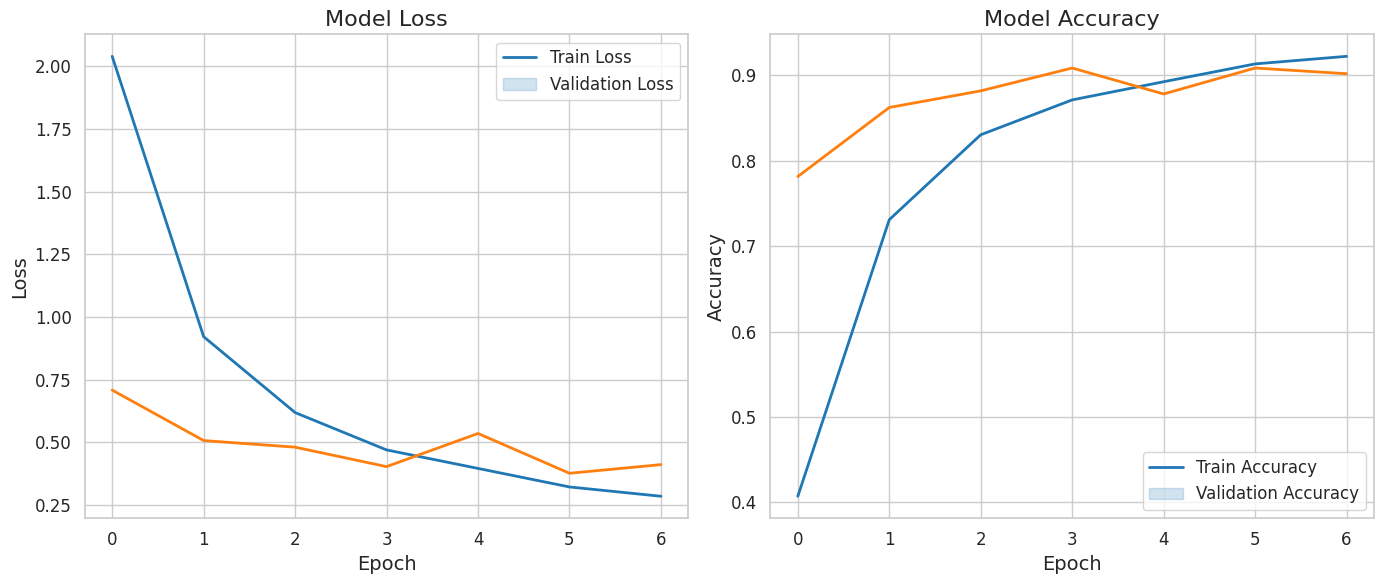

411/411 ━━━━━━━━━━━━━━━━━━━━ 49s 33ms/step - accuracy: 0.9008 - loss: 0.4217
Test Loss: 0.41818901896476746
Test Accuracy: 0.9026764035224915


In [10]:
HIDDEN_SIZE = 512

# early stopping callback
# patience of 3 since we have a small number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",  # Metric to monitor
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
)


base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)
# WE WANT to train the entire model
base_model.trainable = True


# Add custom layers on top of the base model
model = tf.keras.Sequential(
    [
        base_model,
        # This is added to reduce the number of parameters
        tf.keras.layers.GlobalAveragePooling2D(),
        # Add our custom hidden size
        tf.keras.layers.Dense(HIDDEN_SIZE, activation=None),
        # Use a batch normalization layer
        tf.keras.layers.BatchNormalization(),
        # Then the relu
        tf.keras.layers.Activation("relu"),
        # Dropout of 0.4
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
    ]
)

print(model.summary())

# Learning rate is set to 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping]
)

# plot two graphs, one for the train / val loss and one for the train / val accuracy
plot_history(history)

# Finally inference with the best model
results = model.evaluate(test_dataset)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

### Confusion Plot

100%|██████████| 411/411 [02:21<00:00,  2.90it/s]


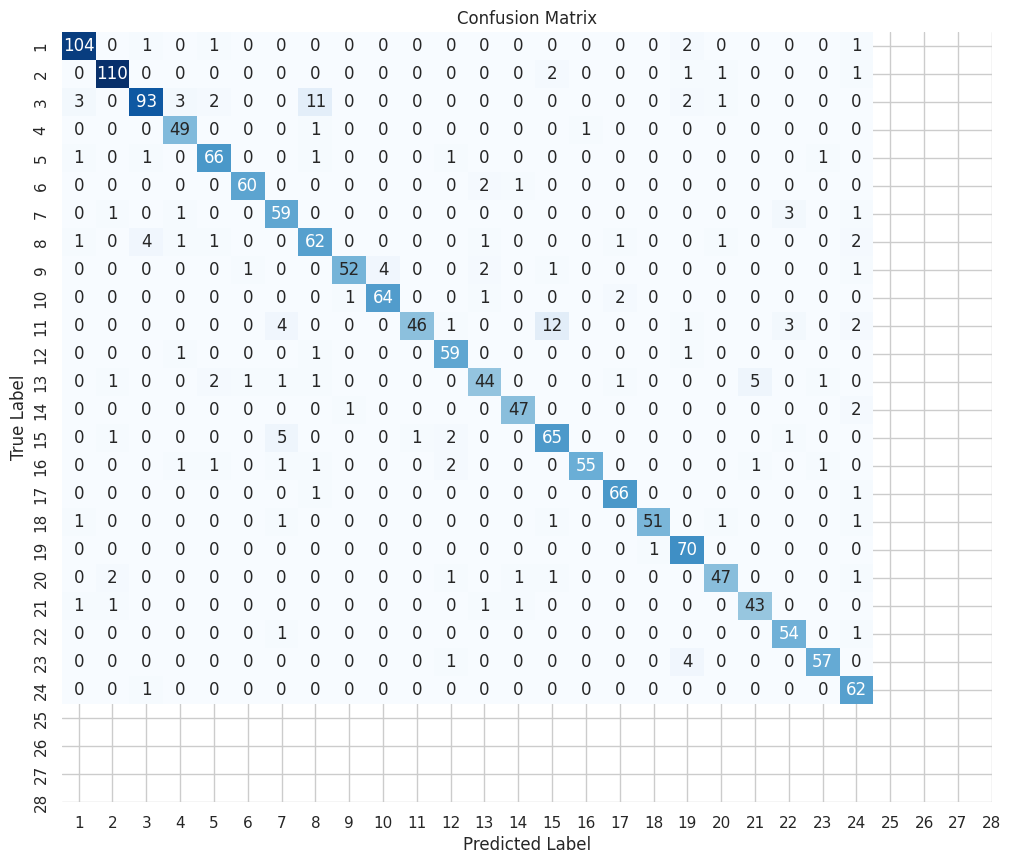

In [11]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = model.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))

class_names = list(range(1, 28 + 1))
plot_confusion_matrix(y_true, y_pred, class_names)